# Reducing science frames

Written by Evgenii N.

The following code reduces individual science images from `data/science_unreduced` directory and saves the reduced images into `data/reduced` directory.

## Prerequisite code

In [1]:
# Import libraries that we will use later in this notebook
import os
import shutil
import ccdproc
import numpy as np
from astropy.visualization import ZScaleInterval, MinMaxInterval, ImageNormalize
from astropy import units as u
from matplotlib.colors import LogNorm
from ccdproc import CCDData
import matplotlib.pyplot as plt

# Make images non-blurry on high pixel density screens
%config InlineBackend.figure_format = 'retina'

# Title size
plt.rcParams['axes.titlesize'] = 16

# Axes label size
plt.rcParams['axes.labelsize'] = 13


def show_image(image, title):
    """
    Display an image.
    
    Parameters
    ---------
    
    image: astropy.nddata.ccddata.CCDData
        A fits image to show.
        
    title: str
        Plot title.
    """
    fig, ax = plt.subplots(figsize=(12, 8))  # Change image size
    plt.rcParams.update({'font.size': 10})  # Change font size
    
    # Scale the image similar to 'zscale' mode in DS9.
    # This makes easier to spot things in the image.
    interval=ZScaleInterval()
    vmin, vmax = interval.get_limits(image)
    norm = ImageNormalize(vmin=vmin, vmax=vmax)
    
    plt.imshow(image, cmap='gray', norm=norm)  # Set color map and pixel scaling
    plt.xlabel('x [pixel]')  # Set axis labels
    plt.ylabel('y [pixel]')
    plt.title(title, y=-0.2)  # Set image title
    plt.colorbar()  # Show color bar
    

def print_image_stats(image, title):
    """
    Print first pixel value, average and standard deviation for an image.
    
    Parameters
    ---------
    
    image: astropy.nddata.ccddata.CCDData
        A fits image to show.
        
    title: str
        Image name.
    """
    
    data = np.asarray(image)# Get numpy array for image data
    label_len = 10  # Length of the text label
    first_pixel = data[0, 0]  # First pixel
    average = np.mean(data)  # Average
    standard_deviation = np.std(data)   # Standard deviation


    # Print values
    # -------

    print(
        f'\n{title}',
        f"\n{'-' * len(title)}",
        f"\n{'Pixel:':<10}{first_pixel:>10.2f} ADU",
        f"\n{'Avg:':<10}{average:>10.2f} ADU",
        f"\n{'Std:':<10}{standard_deviation:>10.2f} ADU\n"
    )
    

def save_image(image, file_path):
    """
    Save image to disk. Overwrites the file if it already exist.
    
    Parameters
    ---------
    image: astropy.nddata.ccddata.CCDData
        Image to be saved
        
    file_path: str
        Path where the image is saved
    """
    
    # Delete the file if it already exists
    
    try:
        os.remove(file_path)
    except OSError:
        pass
    
    # Create directory
    # ------

    dirname = os.path.dirname(file_path)
    
    if not os.path.exists(dirname):
        os.makedirs(dirname)

    image.write(file_path)

# File selection

* I manually look at all the images of NGC 3201 globular cluster with DS9 viewer to make sure they are good. I look at contents of three zip files: March_09_2018.zip, March_29_2018.zip and April_30_2018.zip.
* I copy all the good science images that will be used for reduction into `data/science_frames` directory.

## How I use  DS9

* Click `scale -> zscale` button setting to see stuff better.
* Enable setting `frame -> lock -> scale and limits` to make multiple images have same size and brightness.
* Open four .fits files at a time, for example `NGC_3201_B_60.000secs_00001604.fit`, `NGC_3201_B_60.000secs_00001605.fit`, `NGC_3201_B_60.000secs_00001606.fit` and `NGC_3201_B_60.000secs_00001607.fit`.
* Click `frame -> blink` button to make the viewer alter between the images. This way I can see the differences and spot bad stuff.
* After I finished with the images, close them by pressing `frame -> delete` four times, and then repeat with other four images.


## Files that I excluded from reduction

I looked at all the images for the three nights and discarded the images that were smeared/blurry.

### Discarded images from March_09_2018.zip

* NGC_3201_B_60.000secs_00001645.fit
* NGC_3201_B_60.000secs_00001646.fit
* NGC_3201_B_60.000secs_00001647.fit
* NGC_3201_B_60.000secs_00001648.fit
* NGC_3201_I_60.000secs_00001582.fit
* NGC_3201_I_60.000secs_00001614.fit
* NGC_3201_R_60.000secs_00001572.fit
* NGC_3201_I_60.000secs_00001573.fit
* NGC_3201_R_60.000secs_00001628.fit
* NGC_3201_V_60.000secs_00001598.fit
* NGC_3201_V_60.000secs_00001634.fit
* NGC_3201_V_60.000secs_00001640.fit


## Oversaturated I images

I noticed that the I-filter images from March 9 look oversaturated (Fig. 123). We might need to discard all I-filter images.

![Oversaturated I images ](images/NGC_3201_I_60.000secs_00001617.jpg)
Figure 123: Frame `NGC_3201_I_60.000secs_00001617.fits`, it can be see that large stars are oversaturated and overlapping. This will make it tricky to measure fluxes from those stars.

### Discarded images from March_29_2018.zip

* NGC_3201_B_30.000secs_00000470.fit
* NGC_3201_B_30.000secs_00000471.fit
* NGC_3201_I_30.000secs_00000481.fit
* NGC_3201_R_30.000secs_00000478.fit
* NGC_3201_V_30.000secs_00000474.fit

### Discarded images from April_30_2018.zip

* NGC_3201_B_30.000secs_00001304.fit
* NGC_3201_I_30.000secs_00001314.fit
* NGC_3201_R_30.000secs_00001311.fit


### Images from March 29 and April 30 might be rotated?

Stars in images from March 29 and April 30 look different from those in March 9 (Fig. 124). They might be significantly shifted and rotated. We need to remember this before we combine the images.


![Discarded images from March 29](images/ngc3102_march_09_vs_29.jpg)
Figure 124: Comparing images NGC_3201_B_60.000secs_00001604.fit from March 9 (left) with NGC_3201_B_30.000secs_00000472.fit from March 29 (right). Both images are supposed to be of NGC3201, but they look very different to me. The images are probably significantly shifted with respect to each other, or even rotate/scaled. This is not good :(.

###  Exposures lengths

* Science images in March 29 and April 30 have 5 and 30 second exposures, while all science images from March 9 have 60 sec exposures.
* Vaishali suggested in Lab 7 not to combine science images with different exposures.
* Vaishali suggested in private email to use March 29 and April 30 for photometric callibrations. She said we should then use those callibrations to calculate magnitudes from non-photometric night March 9.

### Science files that I ended up using

The following list contains names of science files that I used.

#### From March_09_2018.zip archive

* NGC_3201_B_60.000secs_00001604.fit
* NGC_3201_B_60.000secs_00001605.fit
* NGC_3201_B_60.000secs_00001606.fit
* NGC_3201_B_60.000secs_00001607.fit
* NGC_3201_B_60.000secs_00001608.fit
* NGC_3201_B_60.000secs_00001609.fit
* NGC_3201_B_60.000secs_00001610.fit
* NGC_3201_B_60.000secs_00001611.fit
* NGC_3201_B_60.000secs_00001612.fit
* NGC_3201_B_60.000secs_00001613.fit
* NGC_3201_B_60.000secs_00001644.fit
* NGC_3201_B_60.000secs_00001649.fit
* NGC_3201_B_60.000secs_00001650.fit
* NGC_3201_B_60.000secs_00001651.fit
* NGC_3201_B_60.000secs_00001652.fit
* NGC_3201_B_60.000secs_00001653.fit
* NGC_3201_I_60.000secs_00001581.fit
* NGC_3201_I_60.000secs_00001584.fit
* NGC_3201_I_60.000secs_00001585.fit
* NGC_3201_I_60.000secs_00001586.fit
* NGC_3201_I_60.000secs_00001587.fit
* NGC_3201_I_60.000secs_00001588.fit
* NGC_3201_I_60.000secs_00001589.fit
* NGC_3201_I_60.000secs_00001590.fit
* NGC_3201_I_60.000secs_00001591.fit
* NGC_3201_I_60.000secs_00001592.fit
* NGC_3201_I_60.000secs_00001593.fit
* NGC_3201_I_60.000secs_00001615.fit
* NGC_3201_I_60.000secs_00001616.fit
* NGC_3201_I_60.000secs_00001617.fit
* NGC_3201_I_60.000secs_00001618.fit
* NGC_3201_I_60.000secs_00001619.fit
* NGC_3201_I_60.000secs_00001620.fit
* NGC_3201_I_60.000secs_00001621.fit
* NGC_3201_I_60.000secs_00001622.fit
* NGC_3201_I_60.000secs_00001623.fit
* NGC_3201_R_60.000secs_00001563.fit
* NGC_3201_R_60.000secs_00001564.fit
* NGC_3201_R_60.000secs_00001565.fit
* NGC_3201_R_60.000secs_00001566.fit
* NGC_3201_R_60.000secs_00001567.fit
* NGC_3201_R_60.000secs_00001568.fit
* NGC_3201_R_60.000secs_00001569.fit
* NGC_3201_R_60.000secs_00001570.fit
* NGC_3201_R_60.000secs_00001571.fit
* NGC_3201_R_60.000secs_00001624.fit
* NGC_3201_R_60.000secs_00001625.fit
* NGC_3201_R_60.000secs_00001626.fit
* NGC_3201_R_60.000secs_00001627.fit
* NGC_3201_R_60.000secs_00001629.fit
* NGC_3201_R_60.000secs_00001630.fit
* NGC_3201_R_60.000secs_00001631.fit
* NGC_3201_R_60.000secs_00001632.fit
* NGC_3201_R_60.000secs_00001633.fit
* NGC_3201_V_60.000secs_00001594.fit
* NGC_3201_V_60.000secs_00001595.fit
* NGC_3201_V_60.000secs_00001596.fit
* NGC_3201_V_60.000secs_00001597.fit
* NGC_3201_V_60.000secs_00001599.fit
* NGC_3201_V_60.000secs_00001600.fit
* NGC_3201_V_60.000secs_00001601.fit
* NGC_3201_V_60.000secs_00001602.fit
* NGC_3201_V_60.000secs_00001603.fit
* NGC_3201_V_60.000secs_00001635.fit
* NGC_3201_V_60.000secs_00001636.fit
* NGC_3201_V_60.000secs_00001637.fit
* NGC_3201_V_60.000secs_00001638.fit
* NGC_3201_V_60.000secs_00001639.fit
* NGC_3201_V_60.000secs_00001641.fit
* NGC_3201_V_60.000secs_00001642.fit
* NGC_3201_V_60.000secs_00001643.fit

#### From March_29_2018.zip archive

* NGC_3201_B_30.000secs_00000472.fit
* NGC_3201_B_5.000secs_00000458.fit
* NGC_3201_B_5.000secs_00000459.fit
* NGC_3201_B_5.000secs_00000460.fit
* NGC_3201_I_30.000secs_00000479.fit
* NGC_3201_I_30.000secs_00000480.fit
* NGC_3201_I_5.000secs_00000467.fit
* NGC_3201_I_5.000secs_00000468.fit
* NGC_3201_I_5.000secs_00000469.fit
* NGC_3201_R_30.000secs_00000476.fit
* NGC_3201_R_30.000secs_00000477.fit
* NGC_3201_R_5.000secs_00000464.fit
* NGC_3201_R_5.000secs_00000465.fit
* NGC_3201_R_5.000secs_00000466.fit
* NGC_3201_V_30.000secs_00000473.fit
* NGC_3201_V_30.000secs_00000475.fit
* NGC_3201_V_5.000secs_00000461.fit
* NGC_3201_V_5.000secs_00000462.fit
* NGC_3201_V_5.000secs_00000463.fit

#### From April_30_2018.zip archive

* NGC_3201_B_30.000secs_00001305.fit
* NGC_3201_B_30.000secs_00001306.fit
* NGC_3201_B_5.000secs_00001292.fit
* NGC_3201_B_5.000secs_00001293.fit
* NGC_3201_B_5.000secs_00001294.fit
* NGC_3201_I_30.000secs_00001313.fit
* NGC_3201_I_30.000secs_00001315.fit
* NGC_3201_I_5.000secs_00001301.fit
* NGC_3201_I_5.000secs_00001302.fit
* NGC_3201_I_5.000secs_00001303.fit
* NGC_3201_R_30.000secs_00001310.fit
* NGC_3201_R_30.000secs_00001312.fit
* NGC_3201_R_5.000secs_00001298.fit
* NGC_3201_R_5.000secs_00001299.fit
* NGC_3201_R_5.000secs_00001300.fit
* NGC_3201_V_30.000secs_00001307.fit
* NGC_3201_V_30.000secs_00001308.fit
* NGC_3201_V_30.000secs_00001309.fit
* NGC_3201_V_5.000secs_00001295.fit
* NGC_3201_V_5.000secs_00001296.fit
* NGC_3201_V_5.000secs_00001297.fit

## CCD temperature check

In `reduce_science_for_filter` function I check that the science and dark image CCD tempeartures differ by no more than 0.5 degree. All dark frames had temperature of -5.23 C. Michael Brown asked us to do this check in Lab 6.

## Program code

In [2]:
def reduce_science_for_filter(filter, reduced_path,
                              fits_path, bias, dark, flat, dark_temp):
    """
    Reduce the science files for the given filter.
    
    Parameters
    ----------
    
    filter: str
        Name of the filter: 'V', 'B' etc.
        
    reduced_path: str
        Path to directory where reduced science images are saved.
        
    fits_path: str
        Directory where science files are located.
        
    bias: astropy.nddata.ccddata.CCDData
        Reduced bias image.
        
    dark: astropy.nddata.ccddata.CCDData
        Reduced dark image.
        
    flat: astropy.nddata.ccddata.CCDData
        Reduced flat image.
        
    dark_temp: float
        Temperature (in degrees) of the CCD in the dark image
        
    Returns
    -------
    
    list of astropy.nddata.ccddata.CCDData
        Reduced science images
    """
    
    print(f"\nReducing science for {filter} filter:")
    
    # Get names of all image files in current directory
    files = ccdproc.ImageFileCollection(fits_path, glob_include = f'*_{filter}_*')
    files = files.files_filtered(PICTTYPE = 1)
        
    # Read the images and store them in a list
    # --------

    sci = [
            CCDData.read(os.path.join(fits_path, file_name), unit="adu")
            for file_name in files
          ]
    
    for file_data in zip(files, sci):
        ccd_temp = file_data[1].header["CCD-TEMP"]
        
        print_text = f'{file_data[0]} ccd_temp={ccd_temp:.2f} C'
        
        # Make sure science and bias temperatures are within 0.5 degrees
        if abs(ccd_temp - dark_temp) > 0.5:
            message = f'Large temperature difference between bias and science\n{print_text}'
            raise RuntimeError(message)
        
        print(print_text)
    
    
    print_image_stats(sci[0], title=f"First science {filter}")
    print(f"First science exposure time: {sci[0].header['EXPTIME']} s")

    # Subtract bias from science frame
    # --------
    
    sci_bias_subtracted = [
        ccdproc.subtract_bias(image, bias)
        for image in sci
    ]

    print_image_stats(sci_bias_subtracted[0], title='Science image, bias subtracted')
    
    # Subtract dark median image from flats.
    # We also scale by exposure time to make sure
    # the effective exposures of two images are equal.
    # --------

    sci_bias_median_subtracted = [
        ccdproc.subtract_dark(image, dark, exposure_time='EXPTIME', 
                              exposure_unit=u.second, scale=True)
        for image in sci_bias_subtracted
    ]

    print_image_stats(sci_bias_median_subtracted[0], title='Science image, dark subtracted')

    # Divide by flat
    # ---------

    sci_bias_median_subtracted_flat_corrected = [
        ccdproc.flat_correct(image, flat)
        for image in sci_bias_median_subtracted
    ]

    print_image_stats(sci_bias_median_subtracted_flat_corrected[0], title='Science image, flat corrected')
    
    # Save reduced science images to disk
    # -------
    
    for reduced, file_name in zip(sci_bias_median_subtracted_flat_corrected, files):
        file_path = os.path.join(reduced_path, file_name)
        save_image(image=reduced, file_path=file_path)

INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]

Bias 
---- 
Pixel:        135.00 ADU 
Avg:          109.28 ADU 
Std:            6.78 ADU

Bias exposure time: 0 s
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]

Dark 
---- 
Pixel:          0.00 ADU 
Avg:           12.46 ADU 
Std:          213.09 ADU

Dark exposure time: 600 s
INFO: using the unit adu passed to the FITS reader instead of the unit adu2 in the FITS file. [astropy.nddata.ccddata]

Reducing science for B filter:
NGC_3201_B_60.000secs_00001604.fit ccd_temp=-4.82 C
NGC_3201_B_60.000secs_00001605.fit ccd_temp=-4.82 C
NGC_3201_B_60.000secs_00001606.fit ccd_temp=-5.23 C
NGC_3201_B_60.000secs_00001607.fit ccd_temp=-4.82 C
NGC_3201_B_60.000secs_00001608.fit ccd_temp=-4.82 C
NGC_3201_B_60.000secs_00001609.fit ccd_temp=-4.82 C
NGC_3201_B_60.000secs_00001610.fit ccd_temp=-5.23 C
NGC_3201_B_60.000

INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu2 in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu2 in the FITS file. [astropy.nddata.ccddata]

Reducing science for I filter:
NGC_3201_I_60.000secs_00001581.fit ccd_temp=-4.82 C
NGC_3201_I_60.000secs_00001584.fit ccd_temp=-5.23 C
NGC_3201_I_60.000secs_00001585.fit ccd_temp=-4.82 C
NGC_3201_I_60.000secs_00001586.fit ccd_temp=-5.23 C
NGC_3201_I_60.000secs_00001587.fit ccd_temp=-5.23 C
NGC_3201_I_60.000secs_00001588.fit ccd_temp=-5.23 C
NGC_3201_I_60.000secs_00001589.fit ccd_temp=-4.82 C
NGC_3201_I_60.000secs_00001590.fit ccd_temp=-5.23 C
NGC_3201_I_60.000secs_00001591.fit ccd_temp=-4.82 C
NGC_3201_I_60.000secs_00001592.fit ccd_temp=-4.82 C
NGC_3201_I_60.000secs_00001593.fit ccd_temp=-4.82 C
NGC_3201_I_60.000secs_00001615.fit ccd_temp=-4.82 C
NGC_3201_I_60.000secs_00001616.fit ccd_temp=-4.82 C
NGC_3201_I_60.000secs_00001617.fit ccd_temp=-4.82 C
NGC_3201_I_60.000secs_00001618.fit ccd_temp=-4.82 C
NGC_3201_I_60.000secs_00001619.fit ccd_temp=-5.23 C
NGC_3201_I_60.000

INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu2 in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu2 in the FITS file. [astropy.nddata.ccddata]

Reducing science for R filter:
NGC_3201_R_60.000secs_00001563.fit ccd_temp=-5.23 C
NGC_3201_R_60.000secs_00001564.fit ccd_temp=-4.82 C
NGC_3201_R_60.000secs_00001565.fit ccd_temp=-4.82 C
NGC_3201_R_60.000secs_00001566.fit ccd_temp=-5.23 C
NGC_3201_R_60.000secs_00001567.fit ccd_temp=-5.23 C
NGC_3201_R_60.000secs_00001568.fit ccd_temp=-4.82 C
NGC_3201_R_60.000secs_00001569.fit ccd_temp=-4.82 C
NGC_3201_R_60.000secs_00001570.fit ccd_temp=-5.23 C
NGC_3201_R_60.000secs_00001571.fit ccd_temp=-4.82 C
NGC_3201_R_60.000secs_00001624.fit ccd_temp=-5.23 C
NGC_3201_R_60.000secs_00001625.fit ccd_temp=-4.82 C
NGC_3201_R_60.000secs_00001626.fit ccd_temp=-5.23 C
NGC_3201_R_60.000secs_00001627.fit ccd_temp=-4.82 C
NGC_3201_R_60.000secs_00001629.fit ccd_temp=-4.82 C
NGC_3201_R_60.000secs_00001630.fit ccd_temp=-4.82 C
NGC_3201_R_60.000secs_00001631.fit ccd_temp=-5.23 C
NGC_3201_R_60.000

INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu2 in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu2 in the FITS file. [astropy.nddata.ccddata]

Reducing science for V filter:
NGC_3201_V_60.000secs_00001594.fit ccd_temp=-4.82 C
NGC_3201_V_60.000secs_00001595.fit ccd_temp=-5.23 C
NGC_3201_V_60.000secs_00001596.fit ccd_temp=-5.23 C
NGC_3201_V_60.000secs_00001597.fit ccd_temp=-4.82 C
NGC_3201_V_60.000secs_00001599.fit ccd_temp=-5.23 C
NGC_3201_V_60.000secs_00001600.fit ccd_temp=-4.82 C
NGC_3201_V_60.000secs_00001601.fit ccd_temp=-4.82 C
NGC_3201_V_60.000secs_00001602.fit ccd_temp=-4.82 C
NGC_3201_V_60.000secs_00001603.fit ccd_temp=-5.23 C
NGC_3201_V_60.000secs_00001635.fit ccd_temp=-4.82 C
NGC_3201_V_60.000secs_00001636.fit ccd_temp=-4.82 C
NGC_3201_V_60.000secs_00001637.fit ccd_temp=-5.23 C
NGC_3201_V_60.000secs_00001638.fit ccd_temp=-5.23 C
NGC_3201_V_60.000secs_00001639.fit ccd_temp=-5.23 C
NGC_3201_V_60.000secs_00001641.fit ccd_temp=-5.23 C
NGC_3201_V_60.000secs_00001642.fit ccd_temp=-4.82 C
NGC_3201_V_60.000

INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu2 in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu2 in the FITS file. [astropy.nddata.ccddata]

Reducing science for B filter:
NGC_3201_B_30.000secs_00000472.fit ccd_temp=-4.82 C
NGC_3201_B_5.000secs_00000458.fit ccd_temp=-5.23 C
NGC_3201_B_5.000secs_00000459.fit ccd_temp=-5.23 C
NGC_3201_B_5.000secs_00000460.fit ccd_temp=-4.82 C

First science B 
--------------- 
Pixel:        170.00 ADU 
Avg:          154.81 ADU 
Std:           30.37 ADU

First science exposure time: 30.0 s

Science image, bias subtracted 
------------------------------ 
Pixel:         35.00 ADU 
Avg:           45.54 ADU 
Std:           29.16 ADU


Science image, dark subtracted 
------------------------------ 
Pixel:         35.00 ADU 
Avg:           44.91 ADU 
Std:           23.88 ADU


Science image, flat corrected 
----------------------------- 
Pixel:         33.47 ADU 
Avg:           44.89 ADU 
Std:           15.57 ADU



INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu2 in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu2 in the FITS file. [astropy.nddata.ccddata]

Reducing science for I filter:
NGC_3201_I_30.000secs_00000479.fit ccd_temp=-5.23 C
NGC_3201_I_30.000secs_00000480.fit ccd_temp=-5.23 C
NGC_3201_I_5.000secs_00000467.fit ccd_temp=-5.23 C
NGC_3201_I_5.000secs_00000468.fit ccd_temp=-5.23 C
NGC_3201_I_5.000secs_00000469.fit ccd_temp=-5.23 C

First science I 
--------------- 
Pixel:        189.00 ADU 
Avg:          168.39 ADU 
Std:           77.82 ADU

First science exposure time: 30.0 s

Science image, bias subtracted 
------------------------------ 
Pixel:         54.00 ADU 
Avg:           59.11 ADU 
Std:           77.62 ADU


Science image, dark subtracted 
------------------------------ 
Pixel:         54.00 ADU 
Avg:           58.48 ADU 
Std:           75.63 ADU


Science image, flat corrected 
----------------------------- 
Pixel:         54.43 ADU 
Avg:           58.46 ADU 
Std:           73.08 ADU



INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu2 in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu2 in the FITS file. [astropy.nddata.ccddata]

Reducing science for R filter:
NGC_3201_R_30.000secs_00000476.fit ccd_temp=-5.23 C
NGC_3201_R_30.000secs_00000477.fit ccd_temp=-4.82 C
NGC_3201_R_5.000secs_00000464.fit ccd_temp=-4.82 C
NGC_3201_R_5.000secs_00000465.fit ccd_temp=-4.82 C
NGC_3201_R_5.000secs_00000466.fit ccd_temp=-4.82 C

First science R 
--------------- 
Pixel:        259.00 ADU 
Avg:          233.08 ADU 
Std:           68.41 ADU

First science exposure time: 30.0 s

Science image, bias subtracted 
------------------------------ 
Pixel:        124.00 ADU 
Avg:          123.80 ADU 
Std:           68.15 ADU


Science image, dark subtracted 
------------------------------ 
Pixel:        124.00 ADU 
Avg:          123.17 ADU 
Std:           65.94 ADU


Science image, flat corrected 
----------------------------- 
Pixel:        123.84 ADU 
Avg:          123.13 ADU 
Std:           63.25 ADU



INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu2 in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu2 in the FITS file. [astropy.nddata.ccddata]

Reducing science for V filter:
NGC_3201_V_30.000secs_00000473.fit ccd_temp=-4.82 C
NGC_3201_V_30.000secs_00000475.fit ccd_temp=-4.82 C
NGC_3201_V_5.000secs_00000461.fit ccd_temp=-4.82 C
NGC_3201_V_5.000secs_00000462.fit ccd_temp=-4.82 C
NGC_3201_V_5.000secs_00000463.fit ccd_temp=-5.23 C

First science V 
--------------- 
Pixel:        238.00 ADU 
Avg:          211.76 ADU 
Std:           41.51 ADU

First science exposure time: 30.0 s

Science image, bias subtracted 
------------------------------ 
Pixel:        103.00 ADU 
Avg:          102.48 ADU 
Std:           40.79 ADU


Science image, dark subtracted 
------------------------------ 
Pixel:        103.00 ADU 
Avg:          101.86 ADU 
Std:           37.00 ADU


Science image, flat corrected 
----------------------------- 
Pixel:         98.54 ADU 
Avg:          101.84 ADU 
Std:           32.13 ADU



INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu2 in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu2 in the FITS file. [astropy.nddata.ccddata]

Reducing science for B filter:
NGC_3201_B_30.000secs_00001305.fit ccd_temp=-4.82 C
NGC_3201_B_30.000secs_00001306.fit ccd_temp=-5.23 C
NGC_3201_B_5.000secs_00001292.fit ccd_temp=-4.82 C
NGC_3201_B_5.000secs_00001293.fit ccd_temp=-4.82 C
NGC_3201_B_5.000secs_00001294.fit ccd_temp=-4.82 C

First science B 
--------------- 
Pixel:        176.00 ADU 
Avg:          158.32 ADU 
Std:           33.07 ADU

First science exposure time: 30.0 s

Science image, bias subtracted 
------------------------------ 
Pixel:         41.00 ADU 
Avg:           49.04 ADU 
Std:           31.92 ADU


Science image, dark subtracted 
------------------------------ 
Pixel:         41.00 ADU 
Avg:           48.42 ADU 
Std:           25.77 ADU


Science image, flat corrected 
----------------------------- 
Pixel:         39.21 ADU 
Avg:           48.39 ADU 
Std:           17.05 ADU



INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu2 in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu2 in the FITS file. [astropy.nddata.ccddata]

Reducing science for I filter:
NGC_3201_I_30.000secs_00001313.fit ccd_temp=-5.23 C
NGC_3201_I_30.000secs_00001315.fit ccd_temp=-4.82 C
NGC_3201_I_5.000secs_00001301.fit ccd_temp=-5.23 C
NGC_3201_I_5.000secs_00001302.fit ccd_temp=-4.82 C
NGC_3201_I_5.000secs_00001303.fit ccd_temp=-5.23 C

First science I 
--------------- 
Pixel:        182.00 ADU 
Avg:          167.70 ADU 
Std:           89.26 ADU

First science exposure time: 30.0 s

Science image, bias subtracted 
------------------------------ 
Pixel:         47.00 ADU 
Avg:           58.42 ADU 
Std:           89.10 ADU


Science image, dark subtracted 
------------------------------ 
Pixel:         47.00 ADU 
Avg:           57.80 ADU 
Std:           87.24 ADU


Science image, flat corrected 
----------------------------- 
Pixel:         47.38 ADU 
Avg:           57.77 ADU 
Std:           85.20 ADU



INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu2 in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu2 in the FITS file. [astropy.nddata.ccddata]

Reducing science for R filter:
NGC_3201_R_30.000secs_00001310.fit ccd_temp=-4.82 C
NGC_3201_R_30.000secs_00001312.fit ccd_temp=-4.82 C
NGC_3201_R_5.000secs_00001298.fit ccd_temp=-4.82 C
NGC_3201_R_5.000secs_00001299.fit ccd_temp=-4.82 C
NGC_3201_R_5.000secs_00001300.fit ccd_temp=-5.23 C

First science R 
--------------- 
Pixel:        258.00 ADU 
Avg:          241.17 ADU 
Std:           73.56 ADU

First science exposure time: 30.0 s

Science image, bias subtracted 
------------------------------ 
Pixel:        123.00 ADU 
Avg:          131.89 ADU 
Std:           73.35 ADU


Science image, dark subtracted 
------------------------------ 
Pixel:        123.00 ADU 
Avg:          131.27 ADU 
Std:           71.03 ADU


Science image, flat corrected 
----------------------------- 
Pixel:        122.84 ADU 
Avg:          131.22 ADU 
Std:           68.54 ADU



INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu2 in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu2 in the FITS file. [astropy.nddata.ccddata]

Reducing science for V filter:
NGC_3201_V_30.000secs_00001307.fit ccd_temp=-5.23 C
NGC_3201_V_30.000secs_00001308.fit ccd_temp=-5.23 C
NGC_3201_V_30.000secs_00001309.fit ccd_temp=-5.23 C
NGC_3201_V_5.000secs_00001295.fit ccd_temp=-5.23 C
NGC_3201_V_5.000secs_00001296.fit ccd_temp=-4.82 C
NGC_3201_V_5.000secs_00001297.fit ccd_temp=-5.23 C

First science V 
--------------- 
Pixel:        222.00 ADU 
Avg:          216.18 ADU 
Std:           40.90 ADU

First science exposure time: 30.0 s

Science image, bias subtracted 
------------------------------ 
Pixel:         87.00 ADU 
Avg:          106.90 ADU 
Std:           40.20 ADU


Science image, dark subtracted 
------------------------------ 
Pixel:         87.00 ADU 
Avg:          106.28 ADU 
Std:           35.81 ADU


Science image, flat corrected 
----------------------------- 
Pixel:         83.23 ADU 
Avg:          10

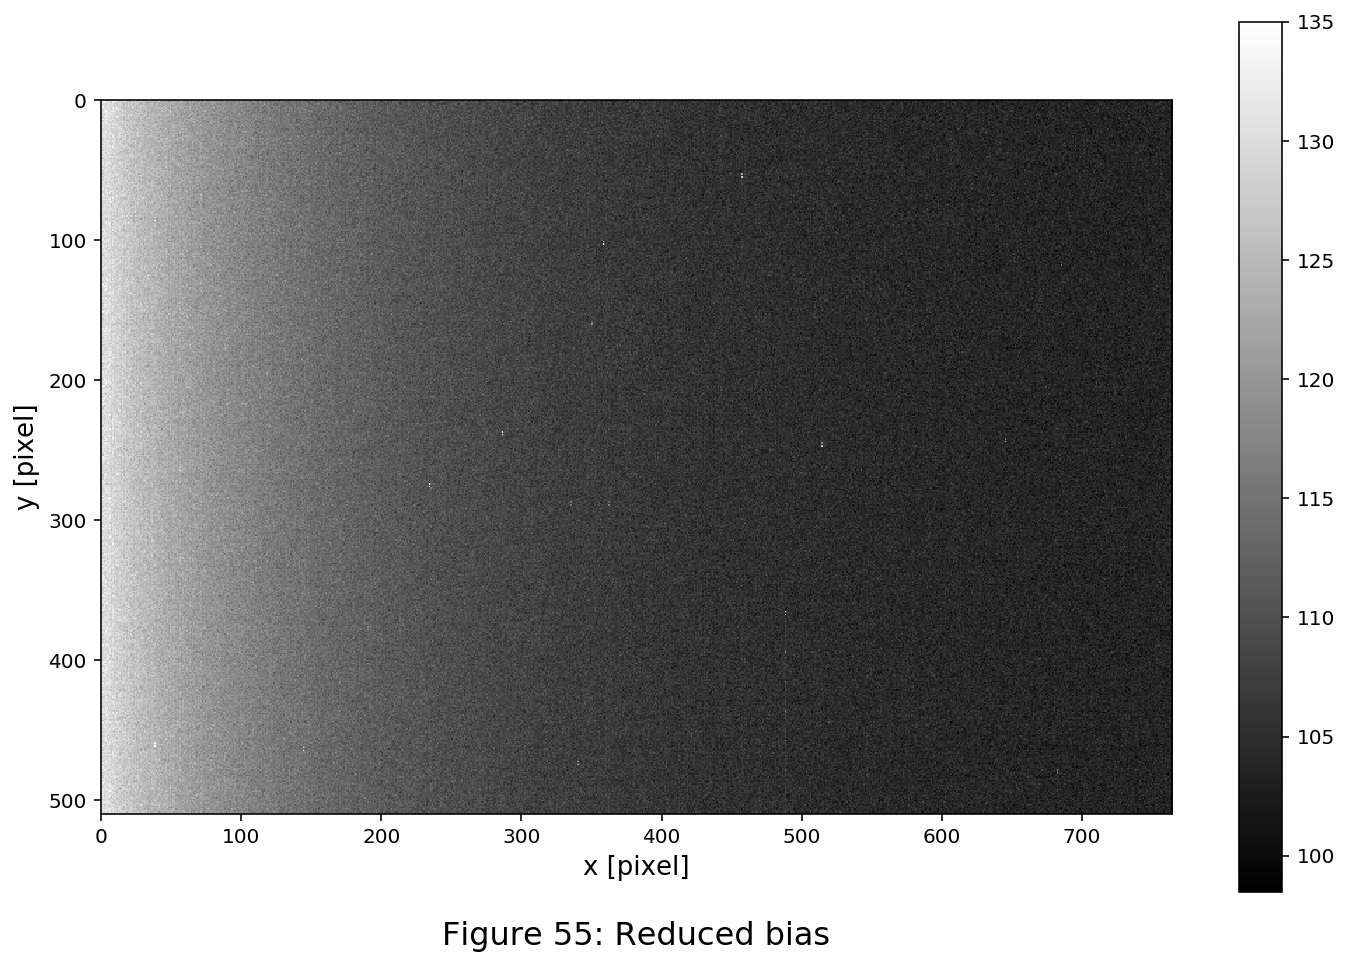

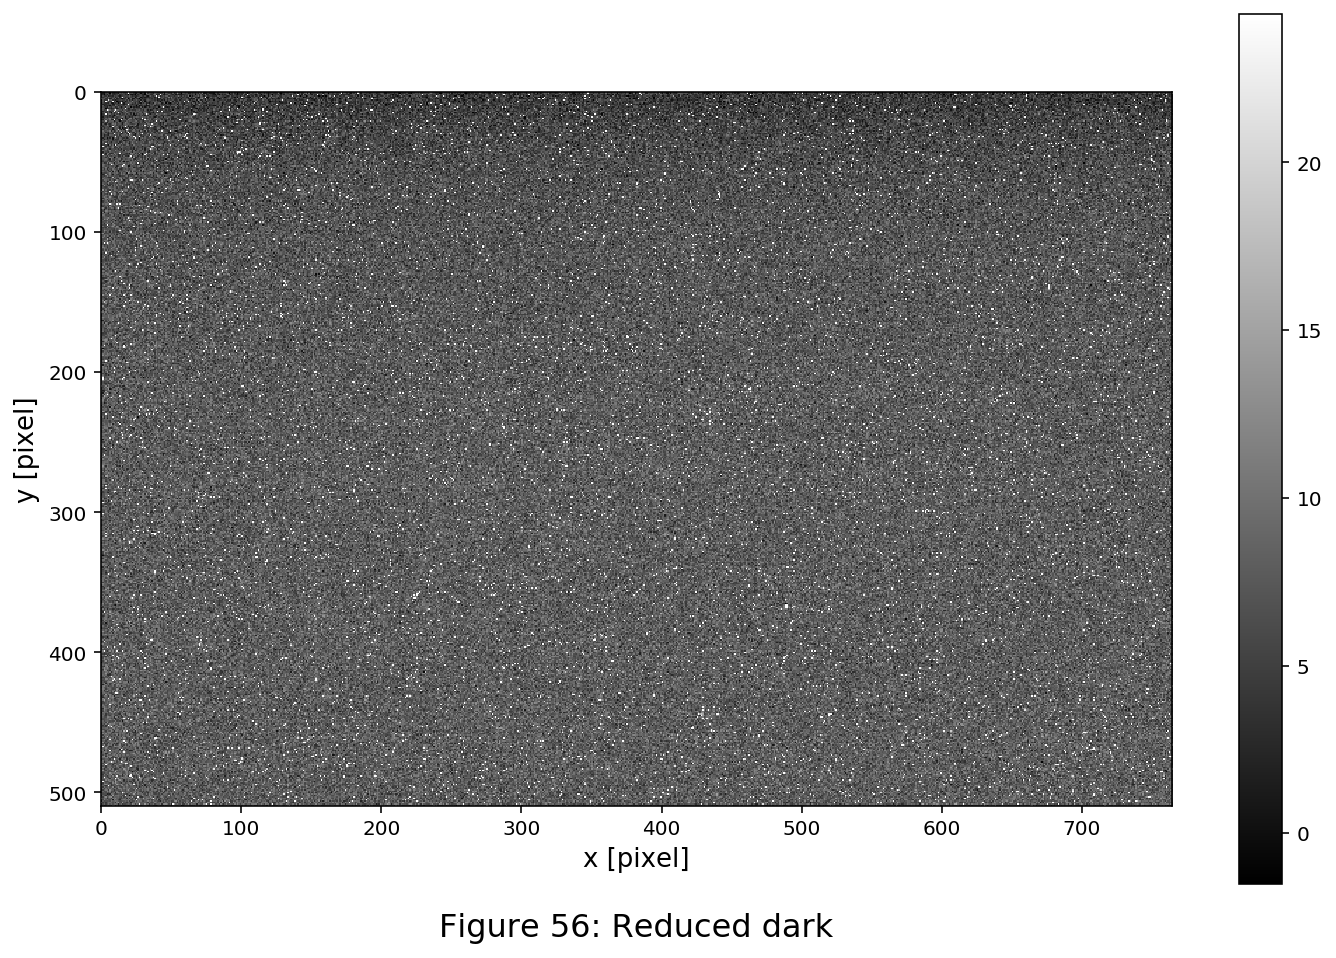

In [3]:
# Set Bias and Dark image paths
# -------

data_dir = './data/'
dark_dir = '../010_bias_and_dark'
flat_dir = '../020_flat/data/flats/reduced'
bias_path = os.path.join(dark_dir, 'bias', 'reduced', 'bias_median.fits')
dark_path = os.path.join(dark_dir, 'dark', 'reduced', 'dark_median.fits')

# Load bias
bias = CCDData.read(bias_path, unit="adu")
show_image(bias, title='Figure 55: Reduced bias')
print_image_stats(bias, title="Bias")
print(f"Bias exposure time: {bias.header['EXPTIME']} s")

# Load dark
dark = CCDData.read(dark_path, unit="adu")
show_image(dark, title='Figure 56: Reduced dark')
print_image_stats(dark, title="Dark")
print(f"Dark exposure time: {dark.header['EXPTIME']} s")

# Reduce images
# -------

nights = ['march_09_2018', 'march_29_2018', 'april_30_2018']

# Reduce images for all nights
for night in nights:
    filters = ['B', "I", "R", "V"]

    # Reduce science frames for all filters
    for i, filter in enumerate(filters):
        # Load flat image
        flat_path = os.path.join(flat_dir, f'flat_{filter}_median.fits')
        flat = CCDData.read(flat_path, unit="adu")

        fits_path = os.path.join(data_dir, f'science_unreduced/{night}')

        sci = reduce_science_for_filter(
            filter=filter,
            reduced_path=os.path.join(data_dir, f'reduced/{night}'),
            fits_path=fits_path,
            bias=bias, dark=dark, flat=flat,
            dark_temp=-5.23)
        
print("------------------")
print("We are done")

## Sanity checks for March 9 images

* The average pixel value of raw science V-band image is about 243 ADU.
* Subtracting bias reduces it to 134 ADU, which is expected, since bias is about 110 ADU.
* Subtracting data reduces it to 133 ADU, which is expected, since dark is 10 adu with exposure 10 times longer than science exposure.
* Dividing by flat does not change the average ADU, which is expected, since flat has average pixel value of 1.
* The average pixel values for images from March 29 and April 30 also look reasonable.

### Science image before and after reduction

A science frame before and after reduction is shown on Fig. 58. I can see that reduction worked because:

* There are fewer hot pixels in reduced image, they were removed after dark subtraction, there are some remaining hot pixels left, which will hopefully be removed when we combine the frames,

* The left side of the raw image has bright glow, which is removed in reduced image after bias subtraction.

* I then manually compare the raw and reduced images for about thirty other frames, found nothing weird, effect of reduction on other frames look like Fig. 58.

![Science](images/sci_before_after.jpg)
Figure 58: Frame `NGC_3201_B_60.000secs_00001604` form March 9 archive before (left) and after (right) reduction. Reduced image has smaller number of hot pixels and not glow in the left side.

I'm ALMOST happy with the reduction code. We still have some hot pixels left in reduced image (right image in Fig. 58). Vaishali said in private email that it's ok to have some hot pixels remaining, we just need to make sure not to measure fluxes from stars that overlap with those hot pixels.